# Preamble
In this notebook a predictive model is built to prevent FPSO platform failures. This can be used in predictive maintenance to avoid corrective maintenance expenses.

The document is divided in some sections
- <a href='#Preprocessing'>Preprocessing</a> where data ar initially processed.
- <a href='#Target'>Target</a> where some caracteristics of the target are examined.
- <a href='#CatVar'>Categorical variables</a> where the configurational state is examinated.
- <a href='#ContVar'>Continuous variables</a> where the nature/root state is examinated.
- <a href='#Models'>Models</a> where the principal models are constructed.
- <a href='#FeatImp'>Importance</a> where the importance of features is estudied.
- <a href='#FeatEng'>Engineering</a> where a feature engineering is made to improve the performance.
- <a href='#Conclusion'>Conclusions</a> where general observations are commented.
- <a href='#Epilogue'>Epilogue</a> where some complementary analyse is included.

In [1]:
#!pip install shap
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier

import shap

## Reading the data

In [3]:
PATH = 'O_G_Equipment_Data.xlsx'
df = pd.read_excel(PATH)

## Preprocessing
Some previous evaluations to see how clean this data is. No null data is found.

<a href='#Preamble'>Back to Preamble</a>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In order to get some information about the behavior of the variables, a *type casting* on the *boolean type* target **Fail** is done to a *type int* value and some plots are visualized.

In [5]:
df['Fail'] = df.Fail.astype(int)

##### Some general observations
- All the data can be simultaneously plotted at this point because there are only a few columns in the table.
- There are only two discrete variables that can be interpreted as categorica: the *Preset* that corresponds to the configuration of the equipment in different settings.
- The faults occur in a well-defined region in the phase space determined by the nature/root variables. This region can be seen in the orange dots in the plots below, located in the upper right of the plots.
- The variable *Cycle*, which should correspond with a certain measure of running time, locates failures in some very specific zones. This could have a predictive value for the model.

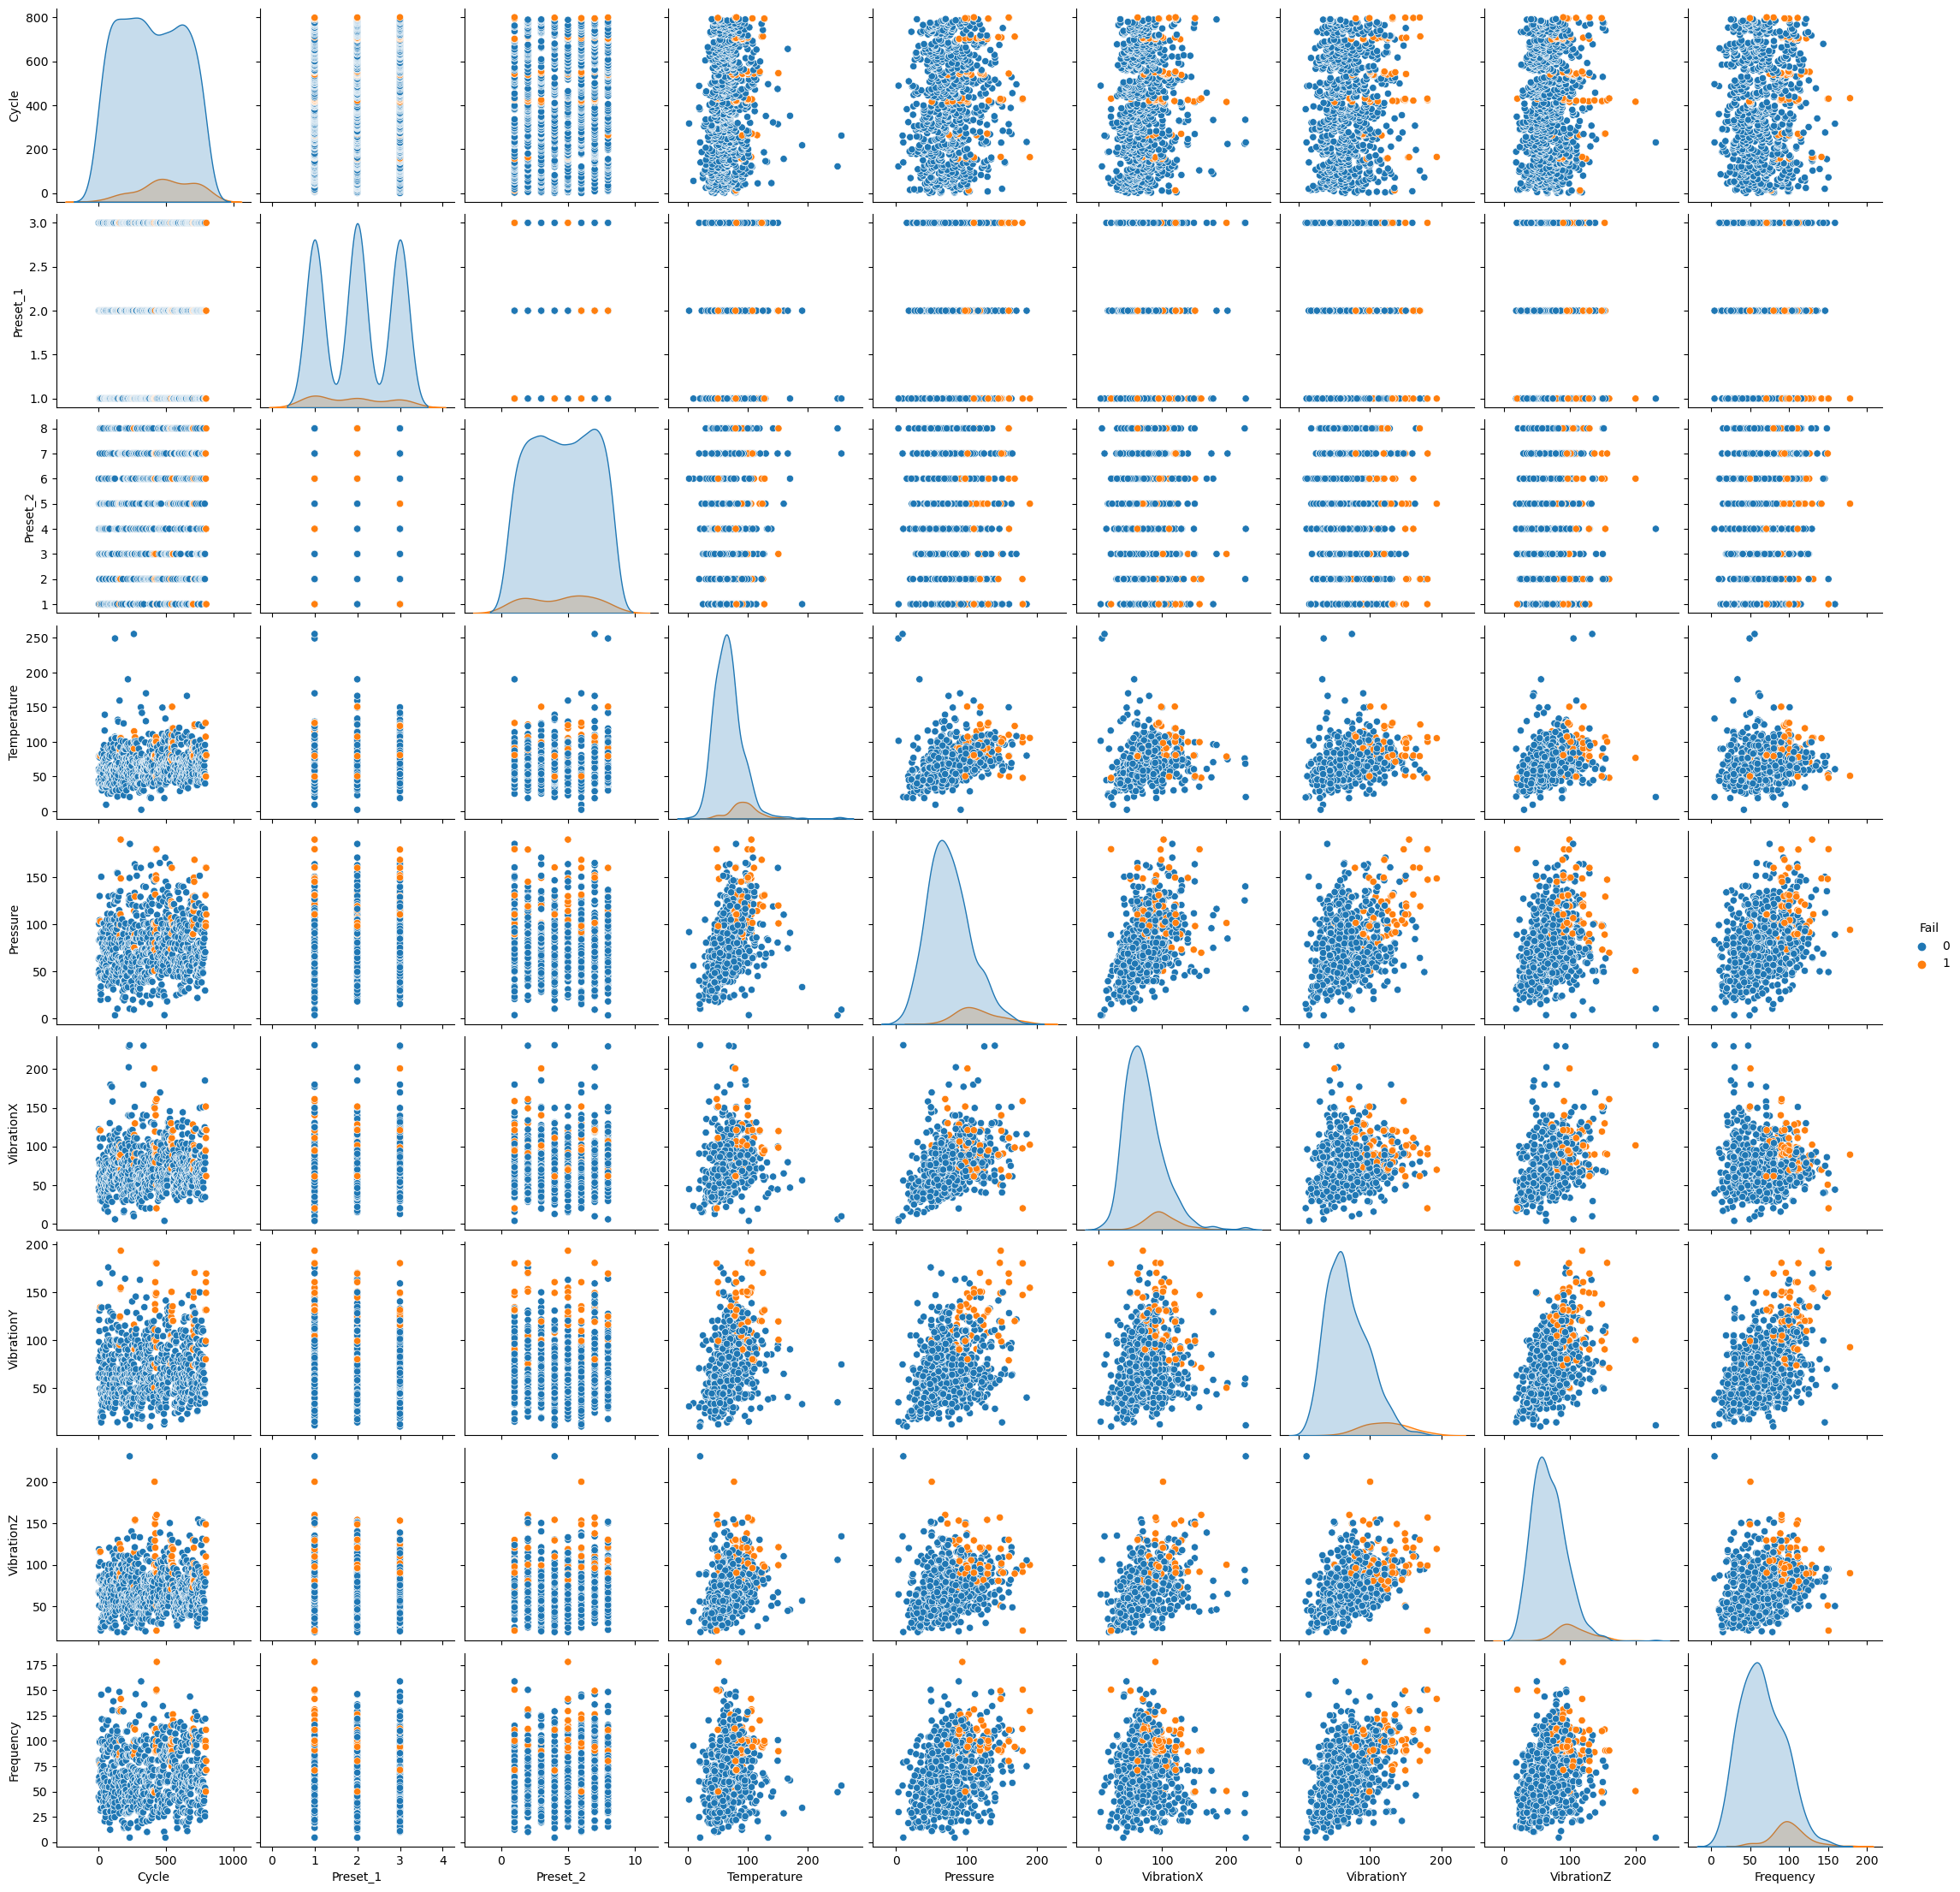

In [6]:
sns.pairplot(df, hue='Fail')
plt.show()

In [7]:
df

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  \
0        1         3         6    44.235186   47.657254   46.441769   
1        2         2         4    60.807234   63.172076   62.005951   
2        3         2         1    79.027536   83.032190   82.642110   
3        4         2         3    79.716242  100.508634  122.362321   
4        5         2         5    39.989054   51.764833   42.514302   
..     ...       ...       ...          ...         ...         ...   
795    796         2         6    50.469522   98.235421  151.585252   
796    797         1         4    49.985270  160.433640  110.953010   
797    798         1         4    79.777294  110.535405   61.334995   
798    799         2         8    79.360314  159.985443   61.762879   
799    800         3         1    80.854011  110.543701  121.032227   

     VibrationY  VibrationZ   Frequency  Fail  
0     64.820327   66.454520   44.483250     0  
1     80.714431   81.246405   60.228715     0  
2     98.254386   98.785196   80.993479     0  
3    121.363429  118.652538   80.315567     0  
4     61.037910   50.716469   64.245166     0  
..          ...         ...         ...   ...  
795   99.341380  148.838481   49.841400     1  
796  160.777175  109.917566  110.919290     1  
797  149.577811  129.463843   70.853353     1  
798  169.773831  130.213426   80.113540     1  
799  131.719473   90.331155   71.261717     1  

[800 rows x 10 columns]

## Target
How many times the equipment has failed
- The equipment have failed $66$ times in the entire registre.
- That corresponds to the $8.25 \%$ of the total data measurements.

<a href='#Preamble'>Back to Preamble</a>

In [8]:
df.Fail.sum(), 100*df.Fail.sum()/df.shape[0] 

(66, 8.25)

## Categorical variables <a id='CatVar'></a>
Now the equipment failures are categorized by setups configurations (preset 1 and 2).

<a href='#Preamble'>Back to Preamble</a>

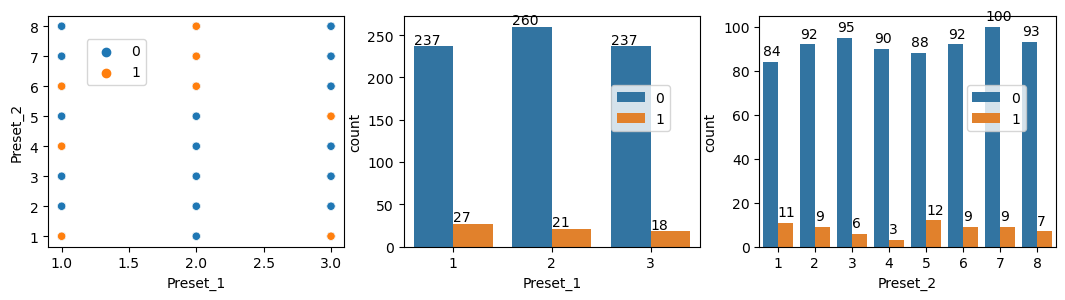

In [9]:
plt.subplots(figsize=(13,3))
plt.subplot(1,3,1)
sns.scatterplot(x='Preset_1', y='Preset_2', hue='Fail', data=df)
plt.legend(loc=(0.13,0.7))

plt.subplot(1,3,2)
ax1 = sns.countplot(x='Preset_1', hue='Fail', data=df)
plt.legend(loc=(0.7,0.5))
for p in ax1.patches:
     ax1.annotate(int(p.get_height()), (p.get_x(), p.get_height()+3))
        
plt.subplot(1,3,3)
ax2 = sns.countplot(x='Preset_2', hue='Fail', data=df)
plt.legend(loc=(0.7,0.5))
for p in ax2.patches:
     ax2.annotate(int(p.get_height()), (p.get_x(), p.get_height()+3))

plt.show()

- The orange dots in the first plot are now studied in detail to see if all failures occur in these cases (see $cell-10$ below and figure at right).
- The second plot shows how many failures occur in each of the *Preset_1* categories. The result is clear that not all *faults* are taken into account in the orange dots shown in the left plot. This is also confirmed by looking at the numbers below.
- The third graph shows some similarity in the behavior of failures in every fourth configuration in the *Preset_2* variable, the most notable being configurations '1' and '5'.

In [10]:
df[df.Preset_1.eq(1) & (df.Preset_2.eq(1) | df.Preset_2.eq(4) | df.Preset_2.eq(6))].Fail.sum(), \
df[df.Preset_1.eq(2) & df.Preset_2.gt(5)].Fail.sum(), \
df[df.Preset_1.eq(3) & (df.Preset_2.eq(1) | df.Preset_2.eq(5))].Fail.sum()

(9, 9, 7)

## Continous variables <a id='ContVar'></a>
Next the equipment failures are categorized by their nature/root cause according to parameter readings (temperature, pressure, and others). A closer look is taken at these characteristics.

<a href='#Preamble'>Back to Preamble</a>

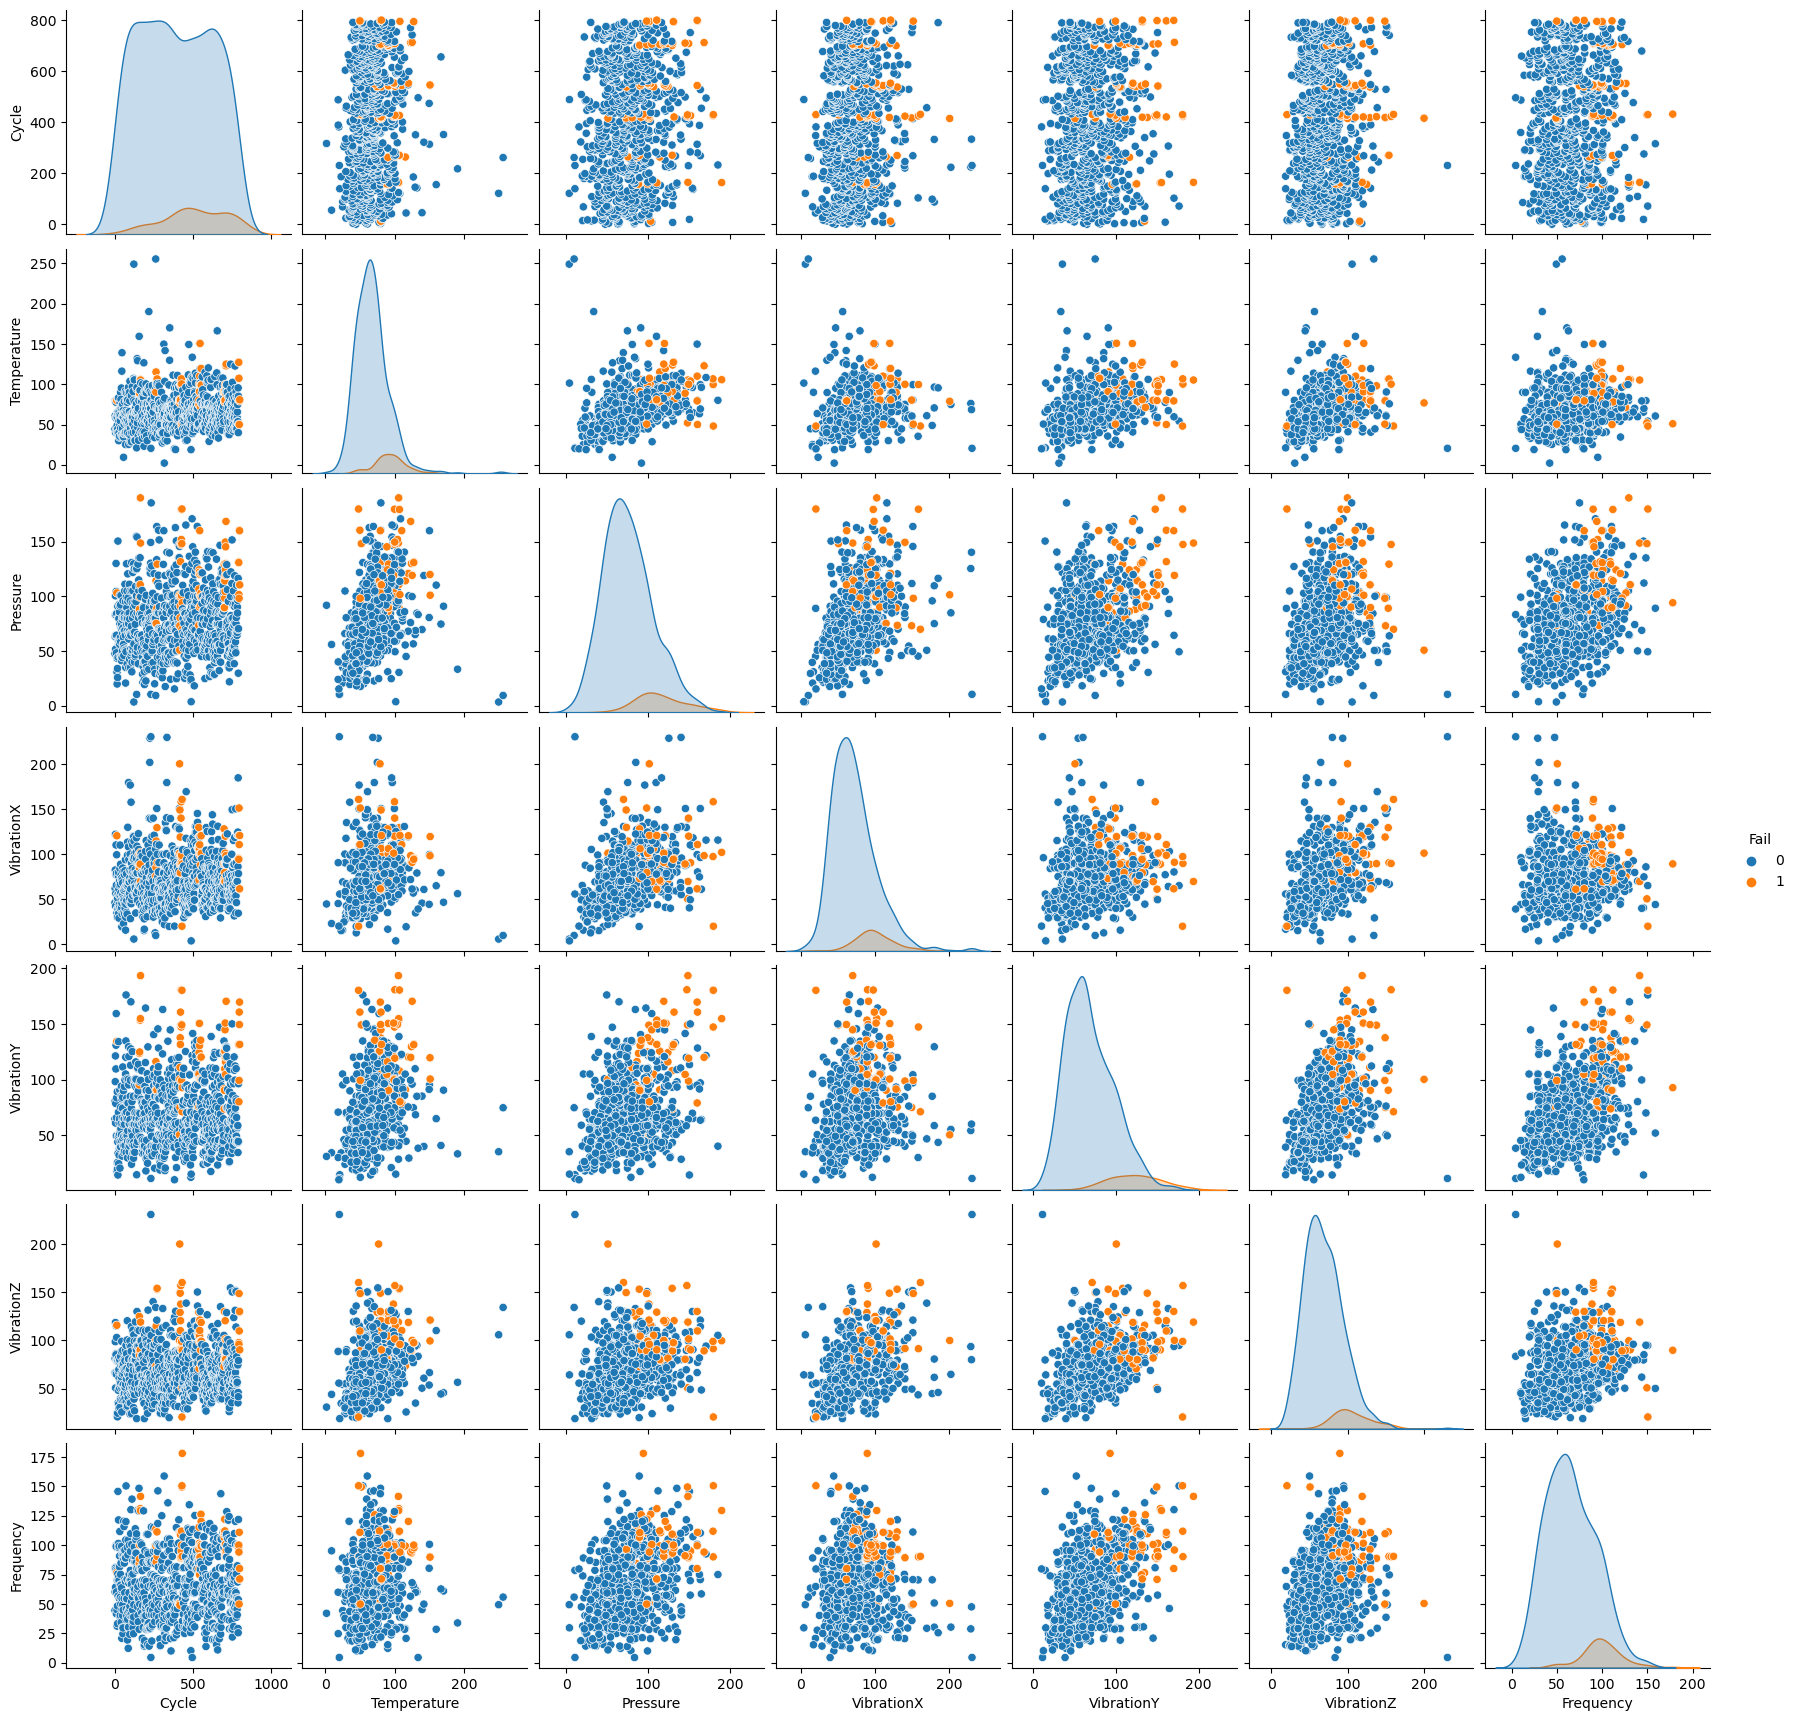

In [11]:
df.drop(columns=['Preset_1','Preset_2'])
sns.pairplot(hue='Fail', data=df.drop(columns=['Preset_1','Preset_2']))
plt.show()

- Even though in most cases the failure points seem to cluster in the region to up and to the right, some points outside this region could make an attempt to develop an unsupervised model difficult.
- In order to determine that region the minimun of each characteristics is calculated next.

In [12]:
df[df.Fail.eq(1)].Temperature.min(), df[df.Fail.eq(1)].Pressure.min()
df[df.Fail.eq(1)].min() - df.min()
#df[df.Temperature.gt(45)].Fail.sum()
#sns.relplot(x='Cycle', y='Temperature',hue='Preset_1', data=df[df.Fail.eq(1)])
#sns.relplot(x='Cycle', y='Temperature',hue='Preset_1', data=df[df.Temperature.gt(45)])
#plt.show()

Cycle          12.000000
Preset_1        0.000000
Preset_2        0.000000
Temperature    46.002608
Pressure       47.341724
VibrationX     16.274125
VibrationY     40.424076
VibrationZ      1.738473
Frequency      44.543676
Fail            1.000000
dtype: float64

- Less data is obtained when restricted to values up to these minima. This could increase the predictive ability of the model by increasing the relevance of the few observed targets. However, less data may affect the training of the model, thus decreasing its predictive ability.
- In order to test this scenario, a smaller dataframe is created ($cell-13$)

In [13]:
df[df.Temperature.gt(df[df.Fail.eq(1)].Temperature.min()-1)&df.Pressure.gt(df[df.Fail.eq(1)].Pressure.min()-1)&
   df.Frequency.gt(df[df.Fail.eq(1)].Frequency.min()-1)&df.VibrationY.gt(df[df.Fail.eq(1)].VibrationY.min()-1)].shape

#100*66/410

(410, 10)

In [14]:
df2 = df[df.Temperature.gt(df[df.Fail.eq(1)].Temperature.min()-1)&df.Pressure.gt(df[df.Fail.eq(1)].Pressure.min()-1)&
   df.Frequency.gt(df[df.Fail.eq(1)].Frequency.min()-1)&df.VibrationY.gt(df[df.Fail.eq(1)].VibrationY.min()-1)].copy()

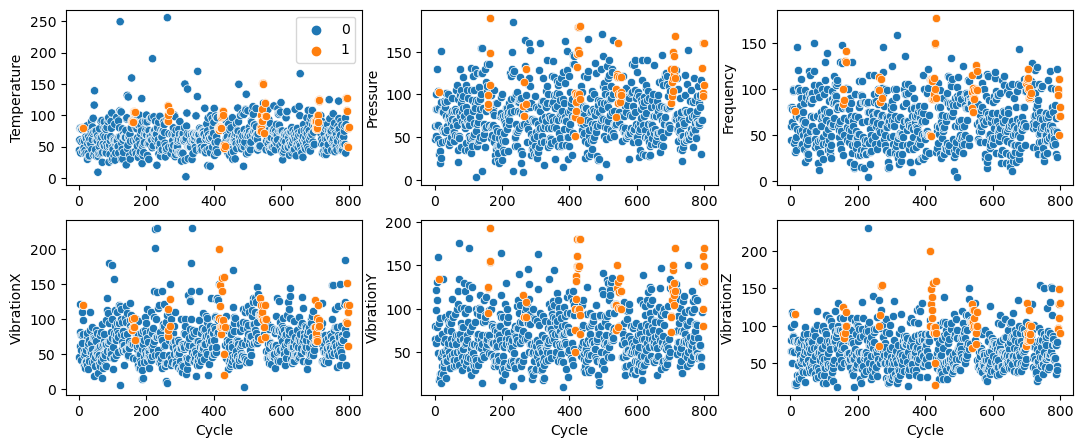

In [15]:
plt.subplots(figsize=(13,5))

plt.subplot(231)
sns.scatterplot(x='Cycle', y='Temperature', hue='Fail', data=df)
sns.scatterplot(x='Cycle', y='Temperature', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')
plt.xlabel('')

plt.subplot(232)
sns.scatterplot(x='Cycle', y='Pressure', data=df)
sns.scatterplot(x='Cycle', y='Pressure', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')
plt.xlabel('')

plt.subplot(233)
sns.scatterplot(x='Cycle', y='Frequency', data=df)
sns.scatterplot(x='Cycle', y='Frequency', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')
plt.xlabel('')

plt.subplot(234)
sns.scatterplot(x='Cycle', y='VibrationX', data=df)
sns.scatterplot(x='Cycle', y='VibrationX', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')

plt.subplot(235)
sns.scatterplot(x='Cycle', y='VibrationY', data=df)
sns.scatterplot(x='Cycle', y='VibrationY', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')

plt.subplot(236)
sns.scatterplot(x='Cycle', y='VibrationZ', data=df)
sns.scatterplot(x='Cycle', y='VibrationZ', data=df[df.Fail.eq(1)])
#plt.vlines(x='Cycle', ymin=0, ymax=175, data=df[df.Fail.eq(1)], color='g')

plt.show()

<a id='Cycle'></a>
- The variable *Cycle* aligns failures every certain number of cycles, clearly defined. This has a strong potential as a predictor. 

##### Some usefull functions

In [16]:
def set_outliers(df, num_cols):
    Q1 = df[num_cols].quantile(.25)
    Q2 = df[num_cols].quantile(.75)
    IQR = Q2 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q2 + 1.5*IQR
    df_return = pd.DataFrame(index=df.index)
    df_return = df[~((df[num_cols] < lower) | (df[num_cols] > upper)).any(axis=1)]
    return df_return

In [17]:
def set_scale(df,num_cols):
    df_result = pd.DataFrame(index=df.index)
    df_result = df.copy()
    df_result[num_cols] = (df[num_cols]-df[num_cols].min(axis=0))/(df[num_cols].max(axis=0)-df[num_cols].min(axis=0))
    return df_result

In [18]:
def set_normal(df,num_cols):
    df_result = pd.DataFrame(index=df.index)
    df_result = df.copy()
    df_result[num_cols] = (df[num_cols]-df[num_cols].mean())/df[num_cols].std()
    return df_result

In [19]:
df.select_dtypes(include='float')
num_cols = df.select_dtypes(include='float').columns
df3 = set_normal(df,num_cols)
#df4 = set_scale(df,num_cols)

In [20]:
def plot_mutual_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()


## Models 
Modeling data to predict failure and measuring its performance 

<a href='#Preamble'>Back to Preamble</a>

### Logistic Regression <a id='LR'></a>
The binary nature of the data sugest a *logistic regression* or some *tree classification* model. 

In [21]:
X = df.copy()
y = X.pop('Fail')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
LR = LogisticRegression(solver='lbfgs', max_iter=5000)

In [24]:
LR.fit(X_train, y_train)
#LR.fit(X, y)

LogisticRegression(max_iter=5000)

In [25]:
LR.coef_, LR.feature_names_in_

(array([[ 0.00422466, -0.12604601, -0.08441405,  0.03739449,  0.01834178,
          0.03864966,  0.04426856,  0.04762708,  0.05449494]]),
 array(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
        'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'],
       dtype=object))

In [26]:
LR.score(X_train, y_train), LR.score(X_test, y_test)

(0.955, 0.955)

In [27]:
y_pred = LR.predict(X_test)

In [28]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')

Accuracy = 0.95
Recall = 0.85



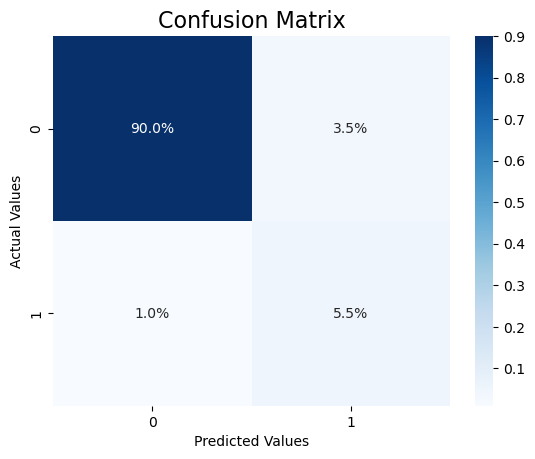

In [29]:
cm = confusion_matrix(y_test, y_pred)
#cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
cm_plot = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.1%')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix', size=16)
plt.show()

In [30]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       187
           1       0.61      0.85      0.71        13

    accuracy                           0.95       200
   macro avg       0.80      0.90      0.84       200
weighted avg       0.96      0.95      0.96       200



- When the prediction is *not fail* (0) but the reality is *fail* (1), we have a cost on our prediction, i.e. **False Negatives must be avoided**. This means that the *recall* of the model should be as large as possible; in this case a **Recall** $= 85%$ was obtained.
- Normalizing the data just makes the *recall* smaller, **Recall** $= 77%$, you can look at this by just running the cells above (from the linear regression $cell-20$ to the metric $cell-29$ in this notebook) but changing the ***X = df.copy()*** by ***X = df3.copy()*** (look at $cell-18$ to see the normalization of the float variables in ***df3***). Thus, in this case, it is preferable not to normalize them.
- Finally, better performance of *Logical Regression* is obtained when a slaightly higher weight is given to the *fail* class (0)

In [31]:
LR = LogisticRegression(class_weight={1:0.65,0:0.35}, solver='lbfgs', max_iter=5000)
LR.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.35, 1: 0.65}, max_iter=5000)

In [32]:
LR.score(X_train, y_train), LR.score(X_test, y_test)

(0.9516666666666667, 0.955)

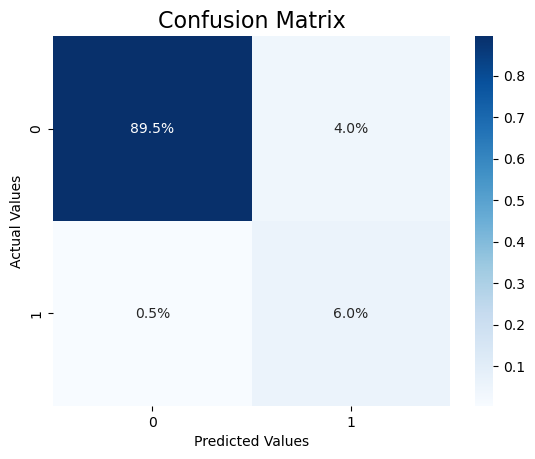

In [33]:
y_pred = LR.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
cm_plot = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.1%')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix', size=16)
plt.show()

In [34]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       187
           1       0.60      0.92      0.73        13

    accuracy                           0.95       200
   macro avg       0.80      0.94      0.85       200
weighted avg       0.97      0.95      0.96       200



- This model performs satisfactorily and could be used as a predictor. 

## Feature importance <a id='FeatImp'></a>
- The importance as predictive variables in this <a href='#LogFeatImp'>logistic regression model</a> is now studied more deeply.
- <a href='#LinCorr'>Linear correlations</a> are also considered in detail, in order to look for some collinearities that could affect model performance.
- Next, some more sophisticated techniques are also considered in order to gain a better understanding of the importance of the variables. 
    - First: The Shap of a <a href='#catboost'>*tree based*</a> classification model.
    - Second: The <a href='#MutInf'>mutual information</a> of the variables.
    
<a href='#Preamble'>Back to Preamble</a>

### Logistic Regression <a id='LogFeatImp'></a>

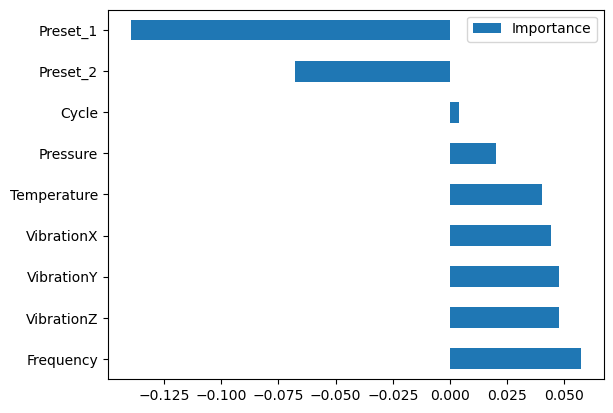

In [35]:
LR.coef_[0]
LR_importance = pd.DataFrame({'Importance':LR.coef_[0]}, index=LR.feature_names_in_)
LR_importance.sort_values(by='Importance', ascending=False,  inplace=True)
LR_importance.plot.barh()
plt.show()

- The two most important characteristics in this logistic regression are the setting statements *Preset_1* and *Preset_2*. The negative direction of these characteristics means that the higher the value of the *Preset* setting, the lower the response of the sigmoid prediction function; in other words, the probability of failure decreases when the *Preset* value increases.
- Whereas, among the other predictive features, the *Frequency* is the most significant, followed by the *Vibration* states (mainly the **Z** and **Y** directions) and *Temperature*.
- **The number of *Cycles* is almost irrelevant for this model. This is useful because the prediction is made without any historical reference or to the running time of the equipment but only to its current state.**

### Linear Correlations <a id='LinCorr'></a>

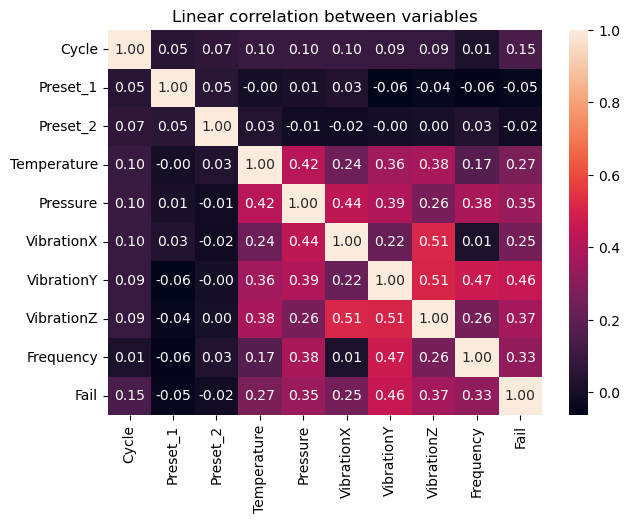

In [36]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), annot=True, fmt='0.2f')
plt.title('Linear correlation between variables')
plt.show()

- A closer look at the Pearson correlations of the variables shows no collinearity between them. Thus, all variables can be considered as independent predictors of the model. 
- A graphical representation of these correlations with the *target* could give some extra insights.

In [37]:
df.corrwith(df.Fail)

Cycle          0.145643
Preset_1      -0.046584
Preset_2      -0.016618
Temperature    0.272666
Pressure       0.345497
VibrationX     0.252754
VibrationY     0.455435
VibrationZ     0.367857
Frequency      0.325286
Fail           1.000000
dtype: float64

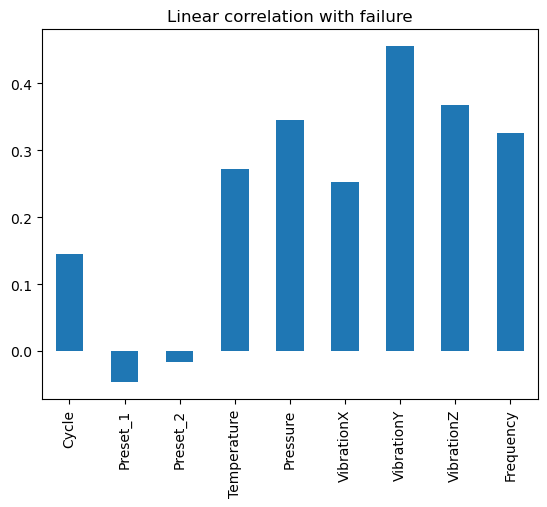

In [38]:
df.drop('Fail',axis=1).corrwith(df.Fail).plot(kind='bar')
plt.title('Linear correlation with failure')
plt.show()

- Again, *Vibrational state* (mainly the **Y** and **Z** directions) also as *Frequency state* are relevant when looking at the failure state.

###  Cat Boost <a id='catboost'></a>
A boosted tree based classifications model is now tested in order to:
- Compare with the previous trained <a href='#LR'>logistic regression.</a>
- Study the importance of features captured by the internal <a href='#CBFI'>catoboost</a> evaluation.
- Study the importance of features captured by the <a href='#SHAP'>shap</a> tecnic.

In [39]:
X = df.copy()
y = X.pop('Fail')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
CB = CatBoostClassifier(verbose=False)

In [42]:
CB.fit(X_train, y_train)

In [43]:
CB.score(X_train, y_train), CB.score(X_test, y_test)

(1.0, 0.955)

In [44]:
y_pred = CB.predict(X_test)

In [45]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')

Accuracy = 0.95
Recall = 0.54



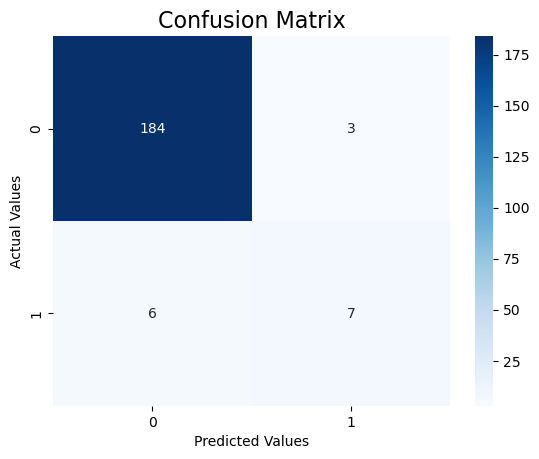

In [46]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d');
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix', size=16)
plt.show()

In [47]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       187
           1       0.70      0.54      0.61        13

    accuracy                           0.95       200
   macro avg       0.83      0.76      0.79       200
weighted avg       0.95      0.95      0.95       200



- The metrics of this model showed worse performance when compared to the Logistic Regression.

In [48]:
CB.feature_importances_, CB.feature_names_

(array([11.19035964,  3.71468202,  4.37692739, 15.72579991, 13.76399175,
         8.48850973, 14.43262743, 12.78160276, 15.52549936]),
 ['Cycle',
  'Preset_1',
  'Preset_2',
  'Temperature',
  'Pressure',
  'VibrationX',
  'VibrationY',
  'VibrationZ',
  'Frequency'])

In [49]:
mod_imp = pd.DataFrame({'Importance':CB.get_feature_importance()}, index=X.columns)
mod_imp.sort_values(by='Importance', ascending=True, inplace=True)

##### Feature Importance <a id='CBFI'></a>

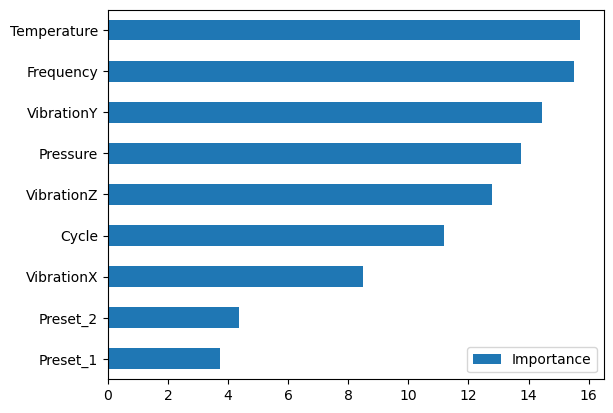

In [50]:
mod_imp.plot.barh()
plt.show()

- Consistent with the previously found insights into the importance of variables as predictors, the *Temperature*, *Frequency*, *Vibration* in **Y** and **Z** appear as major features.
- This model also detects the importance in *Pressure* and *Cycle*.
- The *Preset* $1$ and $2$ states are almost equal in relevance. However, they are the least important variables.

##### Shap <a id='SHAP'></a>

In [51]:
shap.initjs()

In [52]:
explainer = shap.TreeExplainer(CB)
shap_obj = explainer(X_test)
shap_values = explainer.shap_values(X_test)

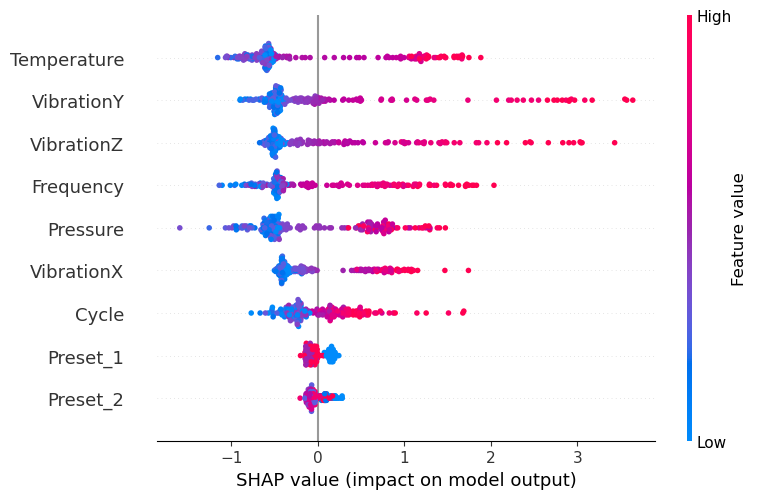

In [53]:
shap.summary_plot(shap_values, X_test)
plt.show()

- Also the importance of variables as predictors with the *Shap* technique detects that *Temperature*, *Vibration* in **Y** and **Z** and *Frequency*, appear as main features.
- The description is very similar to the previous one, based on the internal interpretability of the *catboost* model.
- It can be seen that high values of the so-called nature/root variables give high values of the prediction, which means that the higher the value of the variables, the higher the probability of failure. This corresponds to the well-defined upper right failuer region in phase space, previously commented in this notebook (see comment below $cell-11$). 
- The behavior of the *Preset* variables is opposite: the higher the *Preset* state, the lower the probability of failure. This is also consistent with the previous result founded on the *Logical Regression* analysis (see comment after $cell-35$ above).

### Mutual Information <a id='MutInf'></a>
The mutual information with the target *Fail* variable is now estudied.

In [54]:
X = df.copy()
y = X.pop('Fail')

In [55]:
#X['Cycle'] = X.Cycle.astype('float')
discrete_features = X.select_dtypes('int').columns
discrete_features_indic = []
for feat in X.columns:
    discrete_features_indic.append(feat in discrete_features)
mut_info = mutual_info_classif(X, y, discrete_features=discrete_features_indic, random_state=None, n_neighbors=3)
mut_info = pd.Series(mut_info, name="MI Score (prop)", index=X.columns)
mut_info = mut_info.sort_values(ascending=False)

In [56]:
mut_info

Cycle          0.284833
VibrationY     0.112825
Temperature    0.089547
VibrationZ     0.085930
Frequency      0.072670
Pressure       0.069719
VibrationX     0.059922
Preset_2       0.004982
Preset_1       0.001254
Name: MI Score (prop), dtype: float64

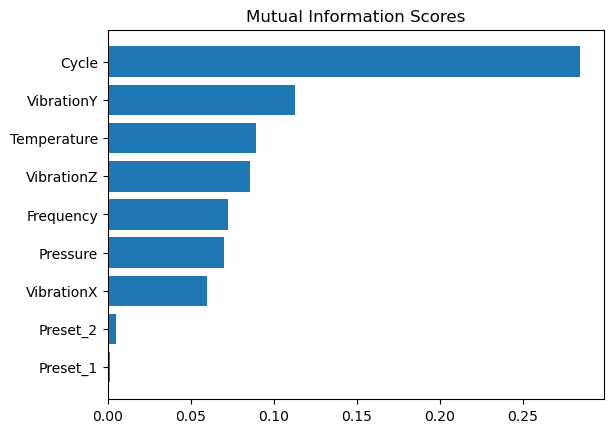

In [57]:
plot_mutual_scores(mut_info)

<a id='MutualInf'></a>
- Mutual information detects a high significance of the *Cycle* variable, as previously intuited (see <a href='#Cycle'>comment below</a> $cell-15$ in this notebook).
- In addition, *Vibration* in **Y** and **Z** directions, also as *Temperature* and *Frequency*, are detected as *most important* by this technique. 
- The configuration states *Preset* $1$ and $2$ do not give much information to the *Failure* state.

## Feature enginering to include the number of cycle as predictor in the models <a id='FeatEng'></a>
Noting the importance of the *Cycle* variable as an informational variable (see <a href='#MutualInf'>mutual information</a> analyzed above and <a href='#Cycle'>the comment below</a> $cell-15$) a <a href='#LR2'>new model</a> that **explicitly includes dependency with the number of cycles without failure** is trained.

<a href='#Preamble'>Back to Preamble</a>

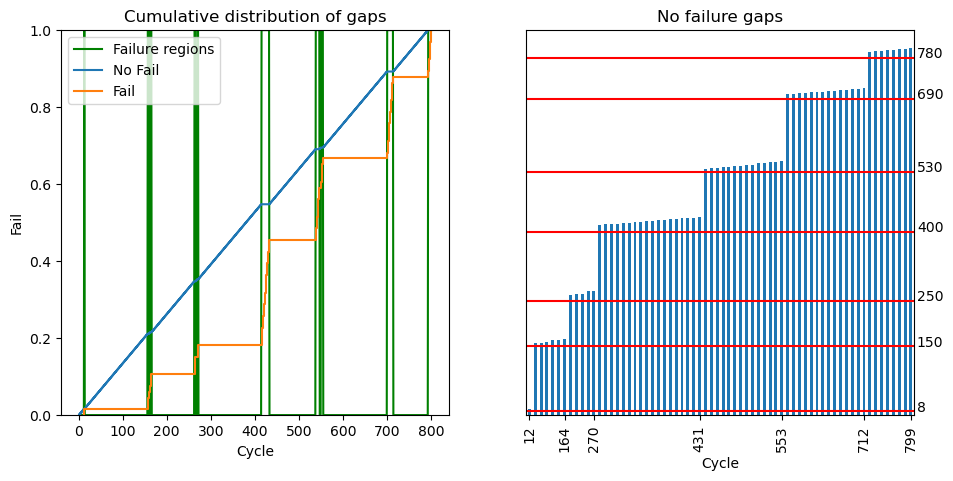

In [58]:
plt.subplots(figsize=(11,5))
plt.subplot(121)
sns.lineplot(x='Cycle', y='Fail', data=df, color='g', label='Failure regions')
sns.ecdfplot(x='Cycle', data=df[df.Fail.eq(0)], label='No Fail')
sns.ecdfplot(x='Cycle', data=df[df.Fail.eq(1)], label='Fail')
plt.title('Cumulative distribution of gaps')
plt.legend()

plt.subplot(122)
df[df.Fail.eq(1)].Cycle.plot(kind='bar')
plt.hlines([8,150,250,400,530,690,780], xmin=-1, xmax=800, color='red')
plt.text(66, 8, '8'),plt.text(66, 150, '150'),plt.text(66, 250, '250'),plt.text(66, 400, '400'),\
plt.text(66, 530, '530'),plt.text(66, 690, '690'),plt.text(66, 780, '780')
plt.xticks([0,6,11,29,43,57,65])
plt.yticks([])
plt.xlabel('Cycle')
plt.title('No failure gaps')

plt.show()

- The predictive value of the variable *Cycle* can be considered explicitly, taking into account cycles in the faulure-free regions between faulires.

In [59]:
failed_cycles = df[df.Fail.eq(1)].Cycle.to_list()
failed_gap = [failed_cycles[i+1] - failed_cycles[i] for i in range(len(failed_cycles)-1)]
no_failure_gaps = [failed_gap[i] for i in range(len(failed_gap)) if failed_gap[i] > 5]
no_failure_gaps
#failed_cycles

[144, 98, 144, 106, 146, 80]

##### A new variable: *no failure gap*
- The *no failure gap* variable, counts the number of cycles without failure.

In [60]:
gf = df.copy()
gf['no_failure_gap'] = 0
for i in range(1, len(gf)):
    if gf.loc[i, 'Cycle'] not in failed_cycles:
        prev_cycle_no_failure_gap = gf.loc[i-1, 'no_failure_gap']
        gf.loc[i, 'no_failure_gap'] = prev_cycle_no_failure_gap + 1

In [61]:
gf.iloc[150:170]

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  \
150    151         2         8    69.989544   61.271076  123.048531   
151    152         3         5    30.303911   80.498461   90.737539   
152    153         2         2    58.460124  114.986843  105.554481   
153    154         2         2    79.784886  105.117910   66.415906   
154    155         3         8    79.583707  135.135115   86.147880   
155    156         2         5   159.547402  110.271759   65.147683   
156    157         3         1    91.695332   85.345796   99.890670   
157    158         2         5    88.916114   88.231887   85.140550   
158    159         3         5    88.768766   99.228691   89.109514   
159    160         1         7    40.861455   63.670593   45.281481   
160    161         1         5    59.566279   83.777553   64.652909   
161    162         2         2    92.501581  135.281156   93.375889   
162    163         1         2   105.969444  110.694610   89.139972   
163    164         1         5   105.695331  189.995681  102.272191   
164    165         1         5   105.275191  148.700443   69.876415   
165    166         1         7   101.791225   99.753196   98.827851   
166    167         3         1    42.679392   49.453376   65.281656   
167    168         1         3    60.386163   61.818300   79.551135   
168    169         1         5    80.063653   82.183823  101.176874   
169    170         1         7    38.784089   52.565241   42.864609   

     VibrationY  VibrationZ   Frequency  Fail  no_failure_gap  
150  113.848664   69.264671   53.371189     0             138  
151   54.580229   45.321520   54.727131     0             139  
152   62.905361   71.444544   79.460160     0             140  
153   59.466134   74.273383  129.128825     0             141  
154   70.127616   95.088050  148.404441     0             142  
155   64.986749  110.305495   28.411528     0             143  
156   95.328429  124.970301   84.377355     1               0  
157  123.711911   88.852872  100.229131     1               0  
158  124.934221   84.306467   88.218162     1               0  
159   48.968916   49.987144   49.695767     0               1  
160   69.696556   70.099087   68.621322     0               2  
161   98.142823  100.395385   80.535575     0               3  
162  153.575928   90.299923  131.072244     1               0  
163  154.904461   99.773163  129.475094     1               0  
164  193.569947  119.136068  141.502855     1               0  
165   99.415648   98.865114  101.783585     0               1  
166   48.072174   62.969165   44.655922     0               2  
167   62.034278   81.498290   58.800498     0               3  
168   82.323819   99.745242   80.359613     0               4  
169   60.443808   50.847601   66.279565     0               5

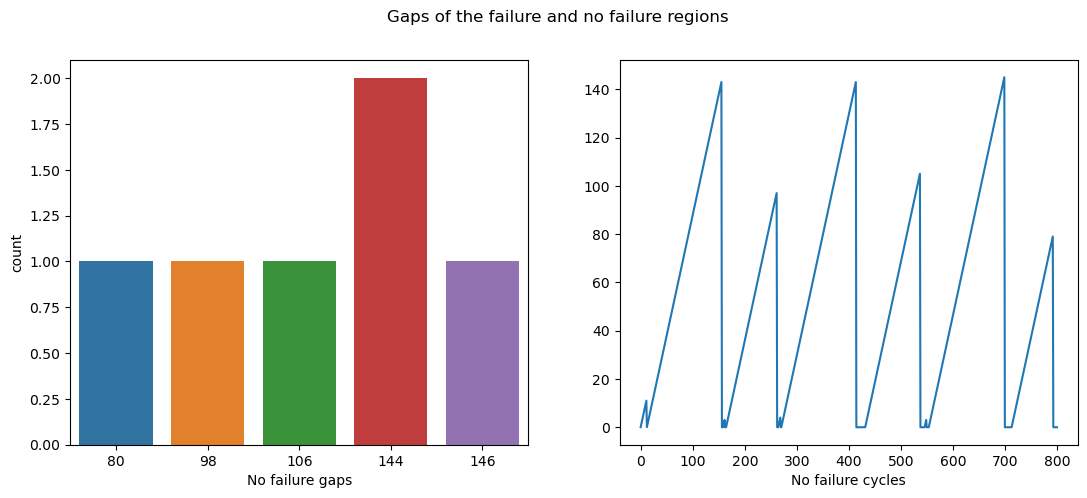

In [62]:
plt.subplots(figsize=(13,5))
plt.suptitle('Gaps of the failure and no failure regions')

#plt.subplot(131)
#sns.countplot(x=failed_gap)
#plt.xlabel('Failure gaps')

plt.subplot(121)
sns.countplot(x=no_failure_gaps)
plt.xlabel('No failure gaps')

plt.subplot(122)
gf['no_failure_gap'].plot()
plt.xlabel('No failure cycles')

plt.show()

- The no-fault gaps showed mainly two large categories of no-fault cycles:
    - A first with about 100 cycles.
    - A second with about 150 cycles.
- Including this as a new feature can improve the predictive ability of the model.

### New Logistic Regression <a id='LR2'></a>
A *logistic regression* is again trained including the new variable, taking into account the no failure gap. 

In [63]:
X = gf.copy()
y = X.pop('Fail')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [65]:
LR = LogisticRegression(solver='lbfgs', max_iter=5000)

In [66]:
LR.fit(X_train, y_train)
#LR.fit(X, y)

LogisticRegression(max_iter=5000)

In [67]:
LR.coef_, LR.feature_names_in_

(array([[ 0.00418963,  0.19093979, -0.17770375, -0.02560876,  0.05687448,
          0.00900181,  0.04242328,  0.03053109,  0.01019213, -2.32965978]]),
 array(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
        'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency',
        'no_failure_gap'], dtype=object))

In [68]:
LR.score(X_train, y_train), LR.score(X_test, y_test)

(1.0, 0.995)

In [69]:
y_pred = LR.predict(X_test)

In [70]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')

Accuracy = 0.99
Recall = 1.00



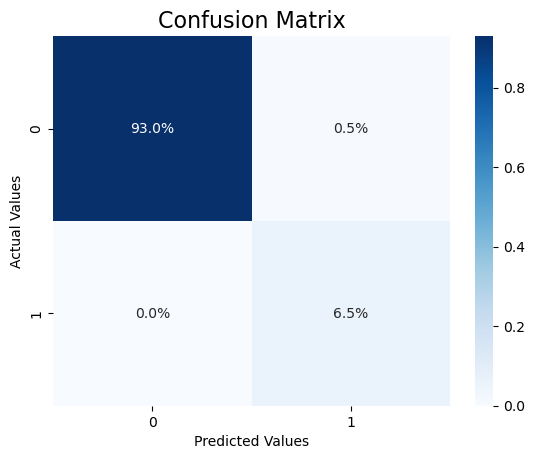

In [71]:
cm = confusion_matrix(y_test, y_pred)
#cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
cm_plot = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.1%')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix', size=16)
plt.show()

In [72]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       187
           1       0.93      1.00      0.96        13

    accuracy                           0.99       200
   macro avg       0.96      1.00      0.98       200
weighted avg       1.00      0.99      1.00       200



### Feature Importance <a id='LogFeatImp2'></a>

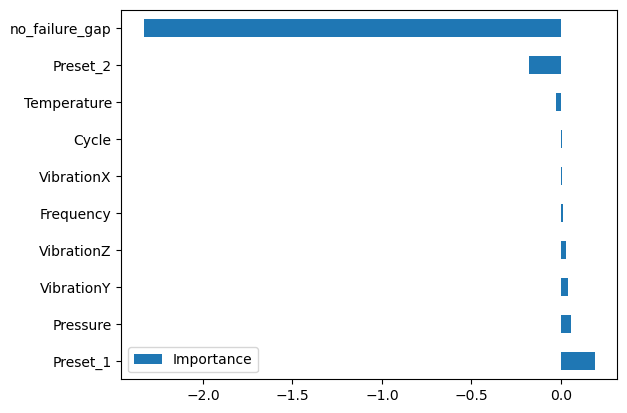

In [73]:
LR.coef_[0]
LR_importance = pd.DataFrame({'Importance':LR.coef_[0]}, index=LR.feature_names_in_)
LR_importance.sort_values(by='Importance', ascending=False,  inplace=True)
LR_importance.plot.barh()
plt.show()

- It can be seen that almost all the importance as predictive feature comes frome the *no failure gap* variable.

# Conclusion
- The data can be used to successfully create a predictive model whose target is the **Fail** variable. This can be used for preventive maintenance.
- Consideration of the importance of features, reveals three key categories of features:
    - The categorical variables **Preset_1** and **Preset_2** with almost equal importance.
    - The continuous variables **VibrationY**, **VibrationZ**, **VibrationX**, **Frequency**, **Temperature** and **Pressure** with almost equal relevance.
    - The discrete variable **Cycle**, with an independent relevance and representing some historical record.
- With this in mind, **two models were be constructed**.
    - The first, with no historical considerations, but only the current state of the equipment as predictor.
    - The other, as the historical record as the greatest predictor.
- The use of both models is strongly recommended to obtain confidence in the recommendation.
- This study shows that a simple logistic regression is sufficient to obtain the desired objetive.
- A possible limitation of the model could come from the low amount of data used to train the model.

<a href='#Preamble'>Back to Preamble</a>

# Epilogue
For completness two other models were studied on <a href='#K-Means'>unsupervisioned</a> and the other <a href='#KNN'>supervisioned</a>, clusterizing by proximity. None of them, neither the <a href='#catboost'>boosted tree-based model</a> after trained, shown a better performances.

<a href='#Preamble'>Back to Preamble</a>

##### K-Means

In [74]:
X = df3[['VibrationZ','VibrationY','Preset_1', 'Frequency','Fail']].copy()
#X = df3.copy()

In [75]:
kmeans = KMeans(n_clusters=2)

X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("int")

X.corr()

VibrationZ  VibrationY  Preset_1  Frequency      Fail   Cluster
VibrationZ    1.000000    0.505651 -0.043808   0.257820  0.367857  0.620693
VibrationY    0.505651    1.000000 -0.062759   0.471990  0.455435  0.672920
Preset_1     -0.043808   -0.062759  1.000000  -0.055360 -0.046584 -0.096558
Frequency     0.257820    0.471990 -0.055360   1.000000  0.325286  0.616169
Fail          0.367857    0.455435 -0.046584   0.325286  1.000000  0.322379
Cluster       0.620693    0.672920 -0.096558   0.616169  0.322379  1.000000

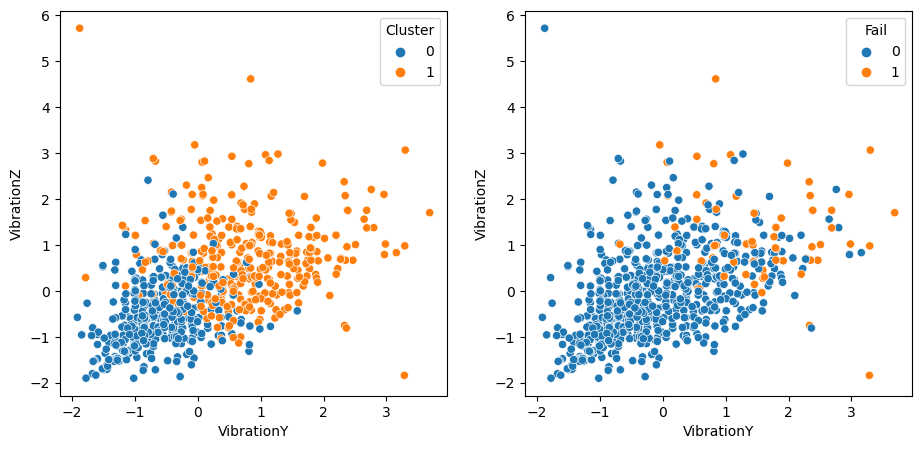

In [76]:
plt.subplots(figsize=(11,5))
plt.subplot(1,2,1)
sns.scatterplot(x='VibrationY', y='VibrationZ', hue='Cluster', data=X)
plt.subplot(1,2,2)
sns.scatterplot(x='VibrationY', y='VibrationZ', hue='Fail', data=X)
plt.show()

##### KNN

In [77]:
X = df.copy()
y = X.pop('Fail')

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [79]:
K = []
train_sc = []
test_sc = []
scores = {}

for k in range(2,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    
    K.append(k)
    train_sc.append(train_score)
    test_sc.append(test_score)
    scores[k] = (train_score, test_score)
    
    #print(f'k {k}, train {train_score}, test {test_score}')

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

In [80]:
for keys, values in scores.items():
    print(keys, ':', values)

2 : (0.9816666666666667, 0.955)
3 : (0.9816666666666667, 0.955)
4 : (0.9683333333333334, 0.955)
5 : (0.965, 0.955)
6 : (0.9633333333333334, 0.96)
7 : (0.9633333333333334, 0.95)
8 : (0.9566666666666667, 0.96)
9 : (0.9583333333333334, 0.955)
10 : (0.95, 0.96)
11 : (0.9516666666666667, 0.945)
12 : (0.9416666666666667, 0.945)
13 : (0.945, 0.945)
14 : (0.94, 0.945)
15 : (0.9416666666666667, 0.94)
16 : (0.9383333333333334, 0.945)
17 : (0.9416666666666667, 0.945)
18 : (0.935, 0.95)
19 : (0.9366666666666666, 0.95)
20 : (0.93, 0.95)


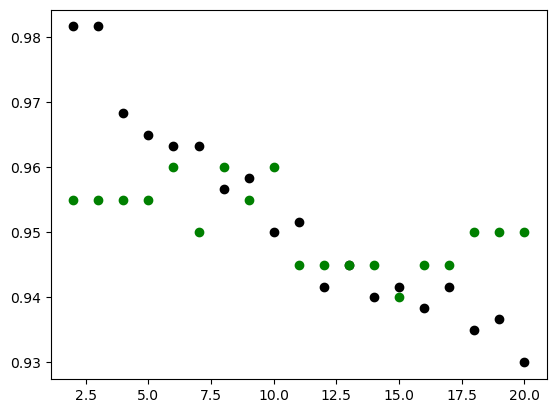

In [81]:
plt.scatter(K, train_sc, color ='k')
plt.scatter(K, test_sc, color ='g')
plt.show()

In [82]:
k = 9
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [83]:
y_pred = knn.predict(X_test)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [84]:
print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\n')

Accuracy = 0.95
Recall = 0.54



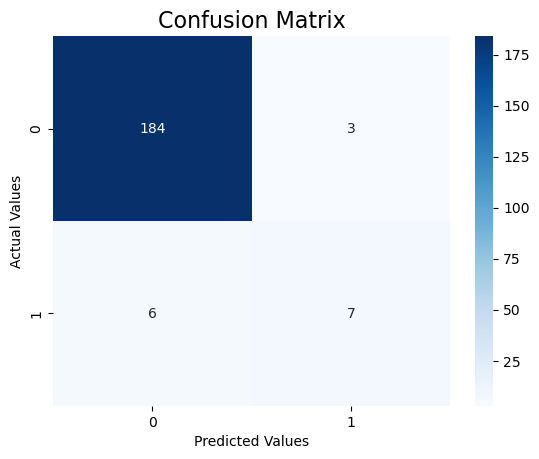

In [85]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d');
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
cm_plot.set_title('Confusion Matrix', size=16)
plt.show()

In [86]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       187
           1       0.70      0.54      0.61        13

    accuracy                           0.95       200
   macro avg       0.83      0.76      0.79       200
weighted avg       0.95      0.95      0.95       200



- <a href='#Conclusion'>Back to Conclusion</a>
- <a href='#Preamble'>Back to Preamble</a>